# SNR measurements
---
#### Overview
* Load and preview images
* Demonstrate SSNR measurement on an individual image
* Compute SNR from SSNR on images in bulk
* Compare SSNR-based SNR measurement with PSD-based method and method from Joy et al. (2002)
* Use SSNR to illustrate differences in low signal vs high signal images

In [1]:
from pathlib import Path
import re
from itertools import product, combinations

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from skimage import img_as_float
from skimage.util import crop
from skimage.external import tifffile

In [2]:
#Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
# Import ssnr code
import ssnr

In [3]:
# Suppress RuntimeWarnings
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

## Load image data
---

In [4]:
# Set filepath for DATA
DATA_dir = Path('../data/SNR_images/')

# Select files and initialize DataFrame
df_bio = pd.DataFrame({'FP': list(DATA_dir.glob('*-mode/*/*/*.tif'))})

# Build up DataFrame
df_bio['MODE'] = df_bio['FP'].apply(lambda x: x.parents[2].name.split('-')[0])
df_bio['LE'] = df_bio['FP'].apply(lambda x: int(re.findall('\d+', x.parents[1].name)[0]))
df_bio['SB'] = df_bio['FP'].apply(lambda x: int(re.findall('\d+', x.parents[1].name)[1]))
df_bio['FIELD'] = df_bio['FP'].apply(lambda x: int(re.findall('\d+', x.parents[0].name)[0]))
df_bio['DWELL'] = df_bio['FP'].apply(lambda x: int(re.findall('\d+', x.stem)[1]))

# Preview
df_bio.sort_values(['MODE', 'SB', 'DWELL'], inplace=True)
df_bio.sample(5)

,FP,MODE,LE,SB,FIELD,DWELL
198,..\data\SNR_images\HR-mode\1500eV-LE__500V-SB\...,HR,1500,500,5,3
392,..\data\SNR_images\UHR-mode\1500eV-LE__500V-SB...,UHR,1500,500,4,20
275,..\data\SNR_images\UHR-mode\1500eV-LE__1500V-S...,UHR,1500,1500,1,10
236,..\data\SNR_images\UHR-mode\1500eV-LE__1000V-S...,UHR,1500,1000,3,1
132,..\data\SNR_images\HR-mode\1500eV-LE__200V-SB\...,HR,1500,200,2,20


### Sample images

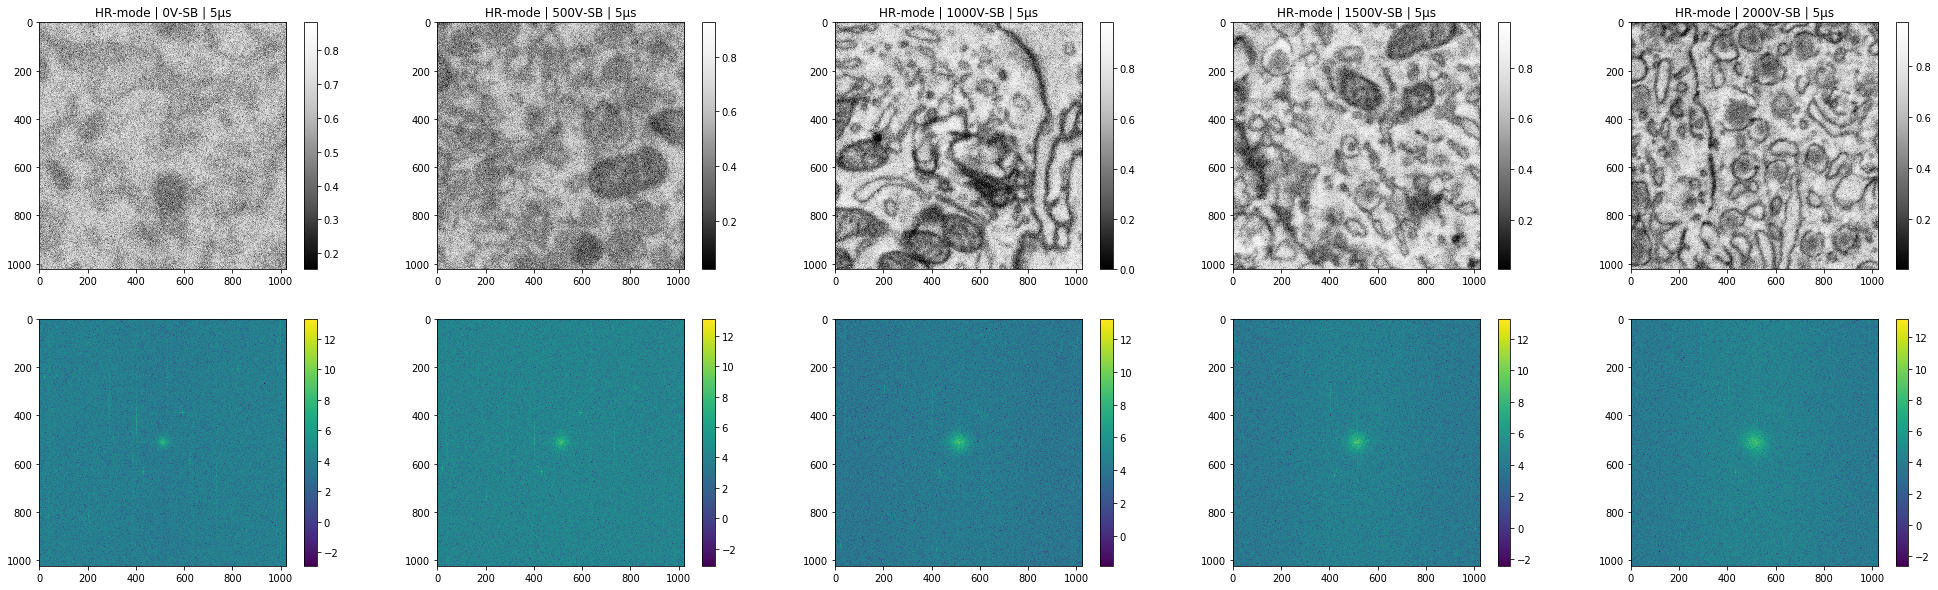

In [5]:
# Sample DataFrame
source = df_bio.loc[(df_bio['SB'].isin([0, 500, 1000, 1500, 2000])) &\
                    (df_bio['DWELL'] == 5)]\
               .groupby('SB')\
               .apply(lambda x: x.head(1))\
               .copy()

# Make figure
fig, axes = plt.subplots(ncols=len(source), nrows=2,
                         figsize=(7*len(source), 5*2))
axmap = {k: v for k, v in zip(source.index, axes.T)}

for i, row in source.iterrows():

    # Plot image
    image = tifffile.imread(row['FP'].as_posix())
    crop_width = (((image.shape[0] - 1024) // 2,) * 2,
                  ((image.shape[1] - 1024) // 2,) * 2)
    cropped = img_as_float(crop(image, crop_width=crop_width, copy=True))
    img = axmap[i][0].imshow(cropped, cmap='Greys_r')
    fig.colorbar(img, ax=axmap[i][0])

    # Compute and plot FFT
    FT_ = np.fft.fft2(cropped)
    FT = np.abs(np.fft.fftshift(FT_))
    fft = axmap[i][1].imshow(np.log(FT))
    fig.colorbar(fft, ax=axmap[i][1])

    # Axis aesthetics
    title = f"{row['MODE']}-mode | {row['SB']}V-SB | {row['DWELL']}µs"
    axmap[i][0].set_title(title)

# Figure aesthetics
plt.subplots_adjust(wspace=0.1)

## SSNR measurements
---
### Individual SSNR measurement

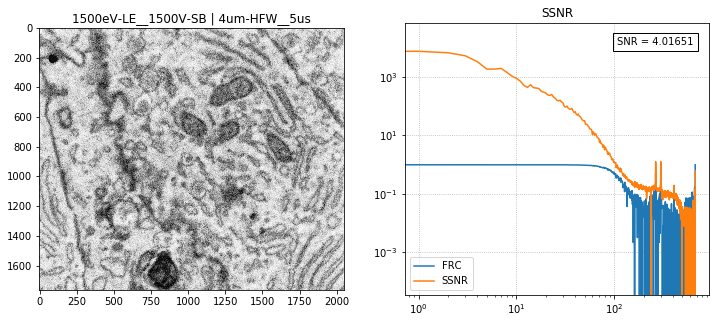

In [6]:
fp = source.sample(1).iloc[0]['FP']
image = img_as_float(tifffile.imread(fp.as_posix()))
images = ssnr.split_image(image)

# Compute FRC, SSNR, and SNR
frc_rings = ssnr.FRC_ring(images[0], images[1])
ssnr_rings = ssnr.SSNR_ring(images)
snr = ssnr.SSNR_full(images)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].imshow(image, cmap='Greys_r')
axes[1].plot(frc_rings, label='FRC')
axes[1].plot(ssnr_rings, label='SSNR')
axes[1].text(0.95, 0.95, f'SNR = {snr:.5f}', ha='right', va='top',
             transform=axes[1].transAxes, bbox={'facecolor':'none'})
# Aesthetics
axes[0].set_title(f'{fp.parents[1].name} | {fp.stem}')
axes[1].set_title('SSNR')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(loc=3)
axes[1].grid(ls=':')

### Series of SSNR measurements

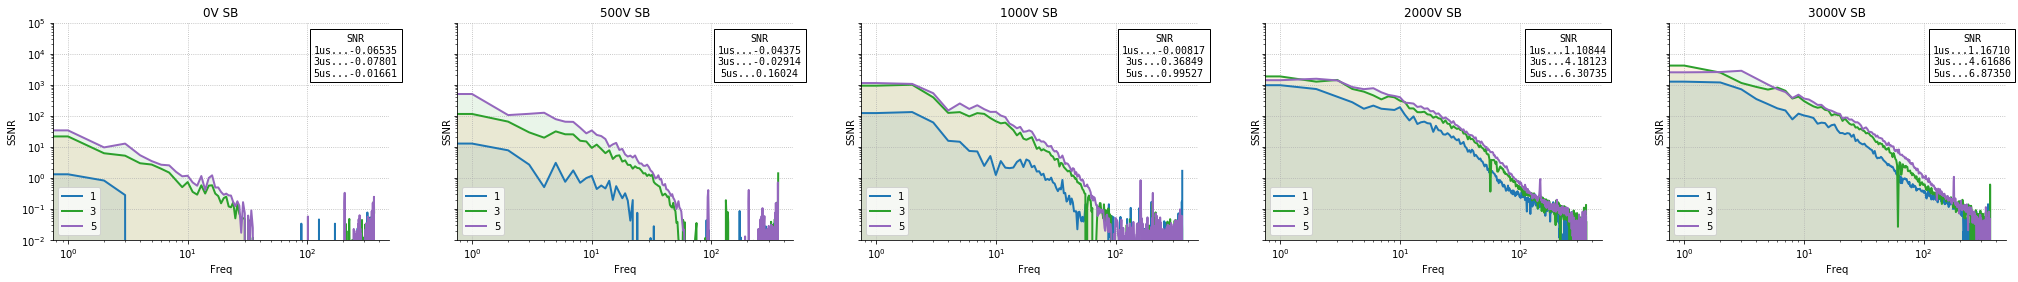

In [7]:
# Filter DataFrame
source = df_bio.loc[(df_bio['MODE'] == 'UHR') &\
                    (df_bio['SB'].isin([0, 500, 1000, 2000, 3000])) &\
                    (df_bio['DWELL'].isin([1, 3, 5]))].copy()

# Make figure (SB varies by row, DWELL varies by col)
ncols = source['SB'].unique().size
nrows = 1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(7*ncols, 4*nrows))
plt.subplots_adjust(hspace=0.5)
axmap = {k: v for k, v in zip(source['SB'].unique(), axes.T.flat)}

# Iterate through subsets of inidivual values for dwell and stage bias
for SB, grp in tqdm(source.groupby('SB')):

    # Set axis
    ax = axmap[SB]
    # Collect SNR measurements
    snr_text = "SNR"

    # Choose one sample per subset to plot
    for i, row in grp.groupby('DWELL').apply(lambda x: x.sample(1)).iterrows():

        # Read image
        image = img_as_float(tifffile.imread(row['FP'].as_posix()))
        crop_width = (((image.shape[0] - 1024) // 2,) * 2,
                      ((image.shape[1] - 1024) // 2,) * 2)
        cropped = crop(image, crop_width=crop_width, copy=True)

        # Compute SNR from SSNR
        images = ssnr.split_image(cropped)
        ssnr_rings = ssnr.SSNR_ring(images)
        snr = ssnr.SSNR_full(images)
        snr_text += f"\n{row['DWELL']}us...{snr:.5f}"

        # Plot SSNR
        cmap = plt.get_cmap('tab10')
        ax.plot(ssnr_rings, lw=2, label=f"{row['DWELL']}", color=cmap(i[0]-1))
        ax.fill_between(np.arange(ssnr_rings.size), 0, ssnr_rings, alpha=0.1)

    # Axis aesthetics
    title = f"{SB}V SB"
    ax.set_title(title)
    ax.text(0.90, 0.95, snr_text, ha='center', va='top', family='monospace',
            transform=ax.transAxes, bbox={'facecolor':'none'})
    ax.set_ylabel('SSNR')
    ax.set_xlabel('Freq')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 1e5)
    ax.legend(loc=3)
    ax.grid(ls=':')
    sns.despine(ax=ax)

### SSNR measurements en masse

In [8]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['MODE', 'SB', 'DWELL', 'SNR'])

# Filter DataFrame
source = df_bio.loc[(df_bio['SB'].isin([0, 500, 1000, 1500, 2000, 3000]))].copy()

# Loop through bioimages
for i, row in tqdm(source.iterrows(),
                   total=len(source)):

    # Load and crop images
    image = img_as_float(tifffile.imread(row['FP'].as_posix()))
    crop_width = (((image.shape[0] - 1024) // 2,) * 2,
                  ((image.shape[1] - 1024) // 2,) * 2)
    cropped = crop(image, crop_width=crop_width, copy=True)

    # Compute SNR from SSNR
    images = ssnr.split_image(cropped)
    snr = ssnr.SSNR_full(images)

    # Populate DataFrame
    df_snr.loc[i, 'MODE'] = row['MODE']
    df_snr.loc[i, 'SB'] = row['SB']
    df_snr.loc[i, 'DWELL'] = row['DWELL']
    df_snr.loc[i, 'SNR'] = snr

# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('MODE')\
      .apply(lambda x: x[::len(df_snr)//10])

MODE    SB  DWELL        SNR
MODE                                 
HR   1     HR     0      1  -0.028422
     178   HR   500      3   0.302011
     29    HR  1000      5   3.677207
     75    HR  1500     10   4.958403
     102   HR  2000     20   6.890689
UHR  201  UHR     0      1  -0.070928
     378  UHR   500      3  -0.007722
     229  UHR  1000      5   0.658984
     275  UHR  1500     10  11.662805
     302  UHR  2000     20  15.759043

### Plot of SNR measurements from SSNR

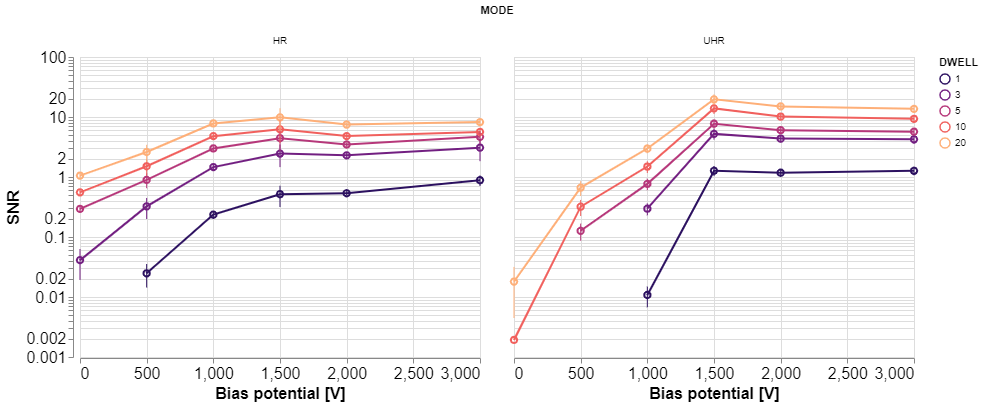

In [9]:
# Data source for plot
source = df_snr.loc[df_snr['SNR'] > 0.001].copy()
# source = df_snr.copy()
scheme = 'magma'

chart = alt.Chart().encode(
    x=alt.X('SB:Q',
            axis=alt.Axis(tickMinStep=500,
                          title='Bias potential [V]')),
    y=alt.Y('SNR:Q',
            aggregate='mean',
            scale=alt.Scale(domain=[0.001, 100], type='log')),
    color=alt.Color('DWELL:N',
                    scale=alt.Scale(scheme=scheme))
)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('SB:Q'),
    y=alt.Y('SNR:Q'),
    color=alt.Color('DWELL:N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).facet(
    column='MODE:N'
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
)

## Comparison to other SNR methods
---
Calculate SNR using three methods
1. Joy et al. (2002)
2. Power spectral density
3. SSNR from Unser et al. (1987)

In [10]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['MODE', 'SB', 'DWELL'])

# Filter DataFrame
source = df_bio.loc[(df_bio['SB'].isin([0, 500, 1000, 1500, 2000, 3000]))].copy()

# Loop through bioimages
for i, row in tqdm(source.iterrows(),
                   total=len(source)):

    # Load and crop images
    image = img_as_float(tifffile.imread(row['FP'].as_posix()))
    crop_width = (((image.shape[0] - 1024) // 2,) * 2,
                  ((image.shape[1] - 1024) // 2,) * 2)
    cropped = crop(image, crop_width=crop_width, copy=True)

    # Compute SNR from JOY
    snr_joy = ssnr.SNR_JOY(cropped)
    # Compute SNR from PSD
    snr_psd = ssnr.SNR_PSD(cropped)
    # Compute SNR from SSNR
    images = ssnr.split_image(cropped)
    snr_ssnr = ssnr.SSNR_full(images)

    # Populate DataFrame
    df_snr.loc[i, 'MODE'] = row['MODE']
    df_snr.loc[i, 'SB'] = row['SB']
    df_snr.loc[i, 'DWELL'] = row['DWELL']
    df_snr.loc[i, 'JOY'] = snr_joy
    df_snr.loc[i, 'PSD'] = snr_psd
    df_snr.loc[i, 'SSNR'] = snr_ssnr

# Preview
df_snr = df_snr.melt(id_vars=['MODE', 'SB', 'DWELL'],
                     var_name='METHOD',
                     value_name='SNR').infer_objects()
df_snr.groupby('METHOD')\
      .apply(lambda x: x.sample(3))

MODE      SB  DWELL METHOD        SNR
METHOD                                          
JOY    179  UHR   500.0    1.0    JOY  -0.121834
       69    HR  1000.0   10.0    JOY   4.651091
       287  UHR  3000.0    5.0    JOY   4.442752
PSD    362   HR  1000.0    5.0    PSD   3.612894
       546  UHR  1500.0   20.0    PSD  23.879123
       481  UHR   500.0    3.0    PSD  -0.366754
SSNR   787  UHR   500.0    5.0   SSNR   0.172691
       751  UHR     0.0    1.0   SSNR  -0.073088
       775  UHR   500.0    1.0   SSNR  -0.059135

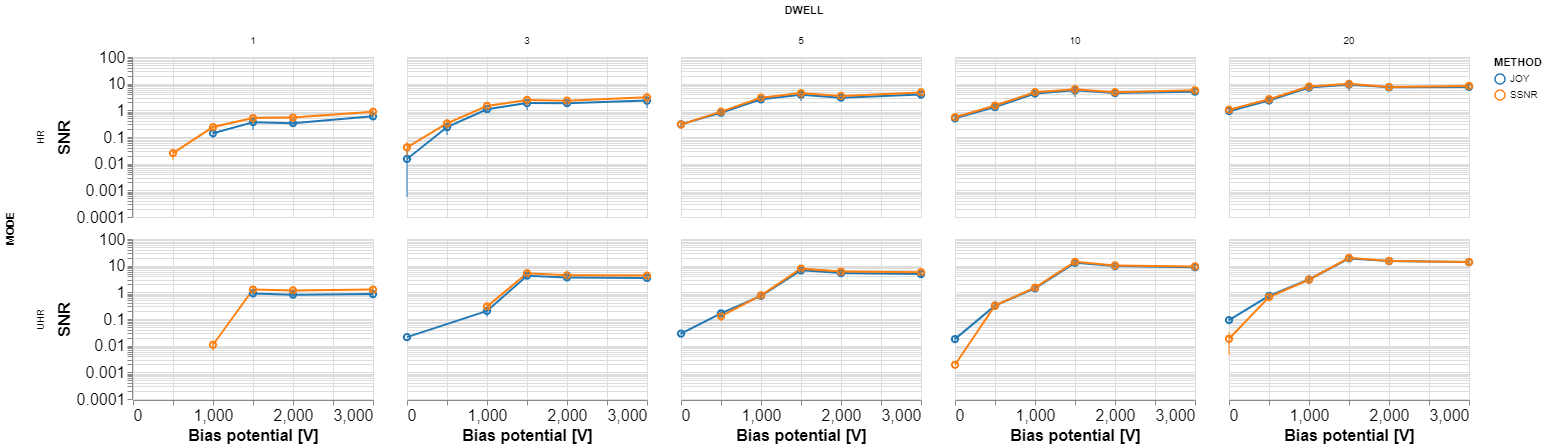

In [11]:
# Data source for plot
# Filter out SNR values that will break log scale
source = df_snr.loc[(df_snr['SNR'] > 0.001) &\
                    (df_snr['METHOD'] != 'PSD')].copy()

# Scale SSNR measurements
scheme = 'category10'

chart = alt.Chart().encode(
    x=alt.X('SB:Q',
            axis=alt.Axis(title='Bias potential [V]',
                          tickMinStep=500)),
    y=alt.Y('SNR:Q',
            aggregate='mean',
            scale=alt.Scale(type='log')),
    color=alt.Color('METHOD:N',
                    scale=alt.Scale(scheme=scheme))
).properties(
    width=240,
    height=160
)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart(source).mark_errorbar(extent='stdev').encode(
    x=alt.X('SB:Q'),
    y=alt.Y('SNR:Q'),
    color=alt.Color('METHOD:N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).facet(
    column=r'DWELL:N',
    row='MODE:N'
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
)

## High noise vs low noise SSNR spectra
---

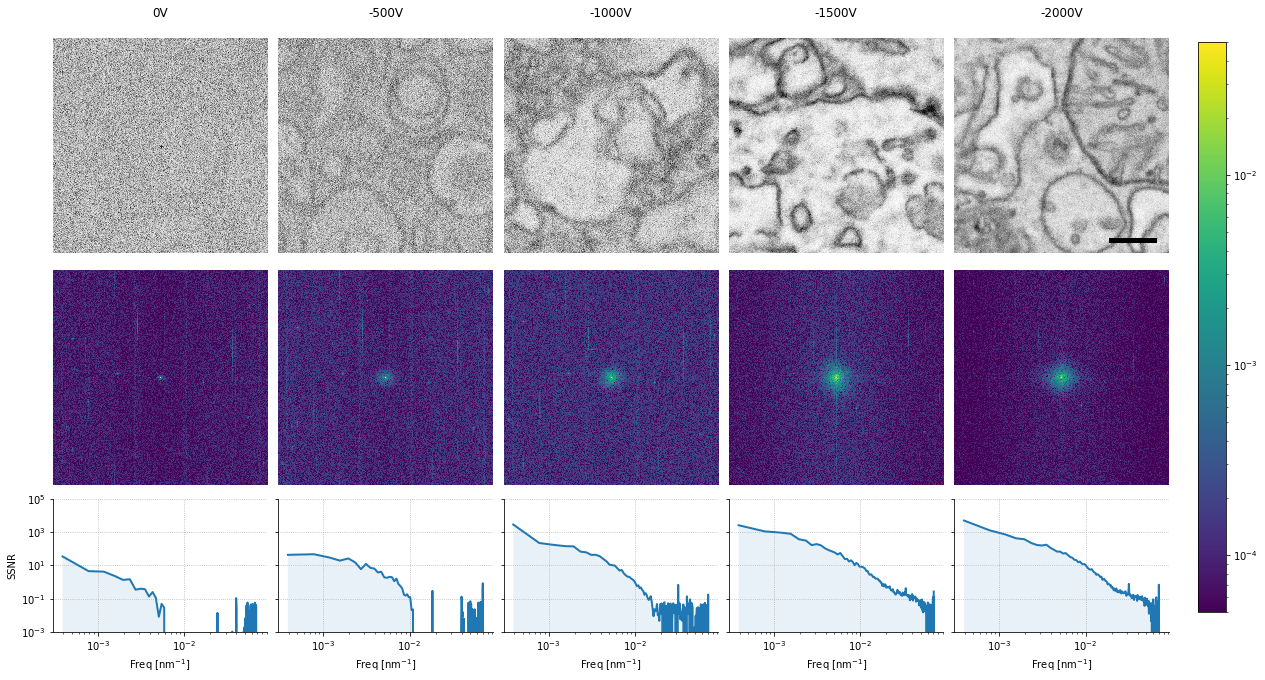

In [12]:
# Sample DataFrame
MODE = 'UHR'
LE = 1500
DWELL = 5
FIELD = 5
SBs = [0, 500, 1000, 1500, 2000]
source = df_bio.loc[(df_bio['MODE'] == MODE) &\
                    (df_bio['LE'] == LE) &\
                    (df_bio['DWELL'] == DWELL) &\
                    (df_bio['FIELD'] == FIELD) &\
                    (df_bio['SB'].isin(SBs))]\
               .copy()

# Make figure
fig, axes = plt.subplots(ncols=len(source), nrows=3,
                         figsize=(4*len(source), 11),
                         gridspec_kw={'height_ratios': [5, 5, 3]})
axmap = {k: v for k, v in zip(source.index, axes.T)}

# Loop through specified set of bio images
for i, row in tqdm(source.iterrows(),
                   total=len(source)):

    # Plot image
    image = img_as_float(tifffile.imread(row['FP'].as_posix()))
    crop_width = (((image.shape[0] - 512) // 2,) * 2,
                  ((image.shape[1] - 512) // 2,) * 2)
    cropped = crop(image, crop_width=crop_width, copy=True)
    axmap[i][0].imshow(cropped, cmap='Greys_r', zorder=0)
    # add 500nm scale bar to 2kV image
    if row['SB'] == 2000:
        axmap[i][0].axhline(480, 0.73, 0.93, color='k', lw=5, zorder=10)

    # Compute and plot FFT
    fft = np.fft.fft2(cropped) / (np.multiply(*cropped.shape))
    fftnorm = np.abs(fft)
    vmin, vmax = (5e-5,  # ~ np.median(np.sort(fftnorm.flat)[:500]),
                  5e-2)  # ~ np.sort(fftnorm.flat)[-2])
    im = axmap[i][1].imshow(np.fft.fftshift(fftnorm),
                            norm=LogNorm(vmin=vmin, vmax=vmax))

    # Compute SSNR
    images = ssnr.split_image(cropped)
    ssnr_data = ssnr.SSNR_ring(images)
    # Calculate frequency
    ps = 5  # pixel size (nm/px)
    N = cropped.shape[0]  # "number of pixels in one direction"
    freq = (np.arange(ssnr_data.size)+1) / (ps * N)

    # Plot PSD
    axmap[i][2].plot(freq, ssnr_data, lw=2)
    axmap[i][2].fill_between(freq, 0, ssnr_data, alpha=0.1)

    # Axis aesthetics
    title = f"{-row['SB']}V"
    axmap[i][0].set_title(title, y=1.07)
    axmap[i][0].axis('off')
    axmap[i][1].axis('off')
    axmap[i][2].set_xlabel('Freq [nm$^{-1}$]')
#     axmap[i][2].set_ylim(vmin, vmax)
    axmap[i][2].set_ylim(1e-3, 1e5)
    axmap[i][2].set_xscale('log')
    axmap[i][2].set_yscale('log')
    axmap[i][2].grid(ls=':')
    sns.despine(ax=axmap[i][2])
    if row['SB'] == 0:
        axmap[i][2].set_ylabel('SSNR')
    else:
        axmap[i][2].set_yticklabels([])

# Figure aesthetics
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
cbar = fig.colorbar(im, cax=cbar_ax)
plt.subplots_adjust(hspace=0.05, wspace=0.05)